# Section 1:  Data Analysis and Pre-Processing

## The Machine Learning Pipeline
Most machine learning workflows consist of 6 steps:
1. Exploratory Analysis: Loading and visualizing your data to understand how it is distributed and how different variables relate to each other.
2. Pre-Processing: Transform your data into a form more amenable to machine learning.
3. Model Training: Optimize one or more machine learning models with your pre-processed data.
4. Model Inference: Apply your machine learning model to data outside your training set.
5. Evaluation: Determine how well your machine learning models have performed.
6. Interpretation: Extract what your model has learned about the data.

In this module, we will cover steps 1 and 2. You will learn about the tutorial dataset, explore it, and perform some pre-processing tasks.

## Introduction to short course data and problem

The goal of the problem is to predict the probability of low-level vorticity exceeding a certain threshold up to ahead given a storm with a simulated radar reflectivity > 40 dBZ and the associated surface wind and temperature fields. 

__Input fields in the netCDF data:__

* REFL_COM_curr (composite reflectivity)

* U10_curr (10 m west-east wind component in m/s)

* V10_curr (10 m south-north wind component in m/s)

* T2_curr (2 m temperature in Kelvin)

__Prediction field:__

* RVORT1_MAX_future (hourly maximum vertical vorticity at 1 km Above ground level in s-1)

__Other fields of note:__

* time: valid time of storm image

* i and j: row and column array indices from original WRF model grid

* x and y: projection coordinates in m

* masks: binary grid showing where storm outline is. Aggregate stats in csv file are extracted from only positive grid points in masks.

## Reading meteorological data files with pandas and xarray

First we need to import the libraries used in this section

In [239]:
%matplotlib inline
import numpy as np
import netCDF4 as nc
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.stats import percentileofscore
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
import os

##### How to find the CSV files and create a sorted list of the found files
To do this, we use the glob library to list all of the *.csv files in the specified directory.

In [2]:
# set the path to the data as a string
path = "../data/track_data_ncar_ams_3km_csv_small/"

# create a list of the files and print it out
files = sorted(glob.glob(path+"/*.csv"))

##### How to read in all of the found CSV files using Pandas and concat all of the content
This method adds the content of all of the csv files into one Python Pandas DataFrame object.  We also print the data's column labels in order to help us determine which keys we can use. 

In [3]:
df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
print(df.keys())

Index(['Step_ID', 'Track_ID', 'Ensemble_Name', 'Ensemble_Member', 'Run_Date',
       'Valid_Date', 'Forecast_Hour', 'Valid_Hour_UTC', 'Duration',
       'Centroid_Lon', 'Centroid_Lat', 'Centroid_X', 'Centroid_Y',
       'Storm_Motion_U', 'Storm_Motion_V', 'REFL_COM_mean', 'REFL_COM_max',
       'REFL_COM_min', 'REFL_COM_std', 'REFL_COM_percentile_10',
       'REFL_COM_percentile_25', 'REFL_COM_percentile_50',
       'REFL_COM_percentile_75', 'REFL_COM_percentile_90', 'U10_mean',
       'U10_max', 'U10_min', 'U10_std', 'U10_percentile_10',
       'U10_percentile_25', 'U10_percentile_50', 'U10_percentile_75',
       'U10_percentile_90', 'V10_mean', 'V10_max', 'V10_min', 'V10_std',
       'V10_percentile_10', 'V10_percentile_25', 'V10_percentile_50',
       'V10_percentile_75', 'V10_percentile_90', 'T2_mean', 'T2_max', 'T2_min',
       'T2_std', 'T2_percentile_10', 'T2_percentile_25', 'T2_percentile_50',
       'T2_percentile_75', 'T2_percentile_90', 'RVORT1_MAX-future_mean',
       'RVOR

### Exploring the CSV data
It's always important to understand your data before you do anything with it!  If you don't understand your data, your analysis will be difficult and conclusions can be incorrect.


##### First lets get a subsection of the data into a DataFrame object by using the labels found by printing the list of keys.

In [10]:
df1 = df.loc[:,['Step_ID', 'U10_mean', 'V10_mean', 'T2_mean']]
df1.head()

,Step_ID,U10_mean,V10_mean,T2_mean
0,d01_REFL_COM_20101024-0000_12_12_000_00,0.19710,5.32790,293.14920
1,d01_REFL_COM_20101024-0000_12_12_001_00,-1.03154,5.33612,292.00092
2,d01_REFL_COM_20101024-0000_12_15_002_00,-0.21393,1.99015,293.00864
3,d01_REFL_COM_20101024-0000_12_15_002_01,1.27862,1.81628,292.64368
4,d01_REFL_COM_20101024-0000_12_15_002_02,0.88129,4.33189,292.39392


##### Once we have the data within a DataFrame, it's easy to get the mean by issuing this command.

In [8]:
df1['T2_mean'].mean()

289.4654436647762

##### It's also easy to create a quick plot

Text(0,0.5,'Temperature')

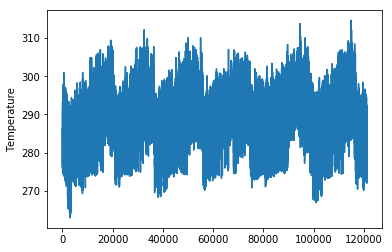

In [12]:
df1['T2_mean'].plot()
plt.ylabel("Temperature")

Text(0.5,1,'Tornadic Storm Spatial Frequency')

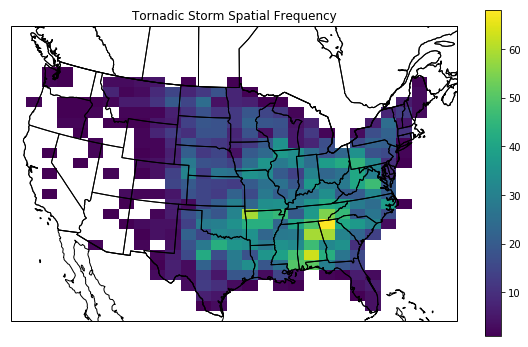

In [249]:
proj = ccrs.LambertConformal()
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=proj)
countries = cfeature.NaturalEarthFeature("cultural", "admin_0_countries", "50m", facecolor="None", edgecolor="k")
states = cfeature.NaturalEarthFeature("cultural", "admin_1_states_provinces", "50m", facecolor="None", edgecolor="k")
ax.add_feature(countries)
ax.add_feature(states)
tor_idx = df["RVORT1_MAX-future_max"] > 0.005
out_points = proj.transform_points(ccrs.PlateCarree(), 
                            df.loc[tor_idx, "Centroid_Lon"].values, df.loc[tor_idx, "Centroid_Lat"].values)
out = ax.hist2d(out_points[:, 0], out_points[:, 1], bins=(np.linspace(-2.5e6, 2.5e6, 30), 
                                                          np.linspace(-1.5e6, 1.8e6, 30)), cmin=1)
ax.set_extent([-2.5e6, 2.5e6, -1.5e6, 1.8e6], crs=proj)
plt.colorbar(out[-1])
plt.title("Tornadic Storm Spatial Frequency")

### Exploring NetCDF files

##### How to find the NetCDF files and create a sorted list of the found files
To do this, we use the glob library to list all of the *.nc files in the specified directory.

In [16]:
# set the path to the data as a string
path = "../data/track_data_ncar_ams_3km_nc_small/"

# create a list of the files and print it out
files = sorted(glob.glob(path+"/*.nc"))
print(files)

['../data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20101024-0000_d01_model_patches.nc', '../data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20101122-0000_d01_model_patches.nc', '../data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110201-0000_d01_model_patches.nc', '../data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110308-0000_d01_model_patches.nc', '../data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110326-0000_d01_model_patches.nc', '../data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110404-0000_d01_model_patches.nc', '../data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110414-0000_d01_model_patches.nc', '../data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110420-0000_d01_model_patches.nc', '../data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110425-0000_d01_model_patches.nc', '../data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110509-0000_d01_model_patches.nc', '../data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110522-0000_d01_model_patches.nc', '../data/track_data_

 ##### Let's read in the first file in the list and see what is in the files.
 
 In the below cell, we open the first file within the file list and print out its summary information.  Afterwards, we close the file.

In [15]:
#  Open the file with the Netcdf library for reading and then close it
nf = nc.Dataset(files[0], "r")
print (nf)
nf.close()

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.6
    title: NCARSTORM Storm Patches for run 20101024-0000 member d01
    object_variable: REFL_COM
    dimensions(sizes): p(1472), row(32), col(32)
    variables(dimensions): int32 p(p), int32 row(row), int32 col(col), float32 lon(p,row,col), float32 lat(p,row,col), int32 i(p,row,col), int32 j(p,row,col), float32 x(p,row,col), float32 y(p,row,col), int32 masks(p,row,col), int32 time(p), float32 centroid_lon(p), float32 centroid_lat(p), float32 centroid_i(p), float32 centroid_j(p), int32 track_id(p), int32 track_step(p), float32 REFL_COM_curr(p,row,col), float32 U10_curr(p,row,col), float32 V10_curr(p,row,col), float32 T2_curr(p,row,col), float32 RVORT1_MAX_future(p,row,col), float32 HAIL_MAXK1_future(p,row,col)
    groups: 



##### Now lets open a file with xarray and print its content

As you probably have noticed, the output format is easier to read.

In [17]:
xf = xr.open_dataset(files[0])
print (xf)

<xarray.Dataset>
Dimensions:            (col: 32, p: 1472, row: 32)
Coordinates:
  * p                  (p) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * row                (row) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
  * col                (col) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
Data variables:
    lon                (p, row, col) float32 ...
    lat                (p, row, col) float32 ...
    i                  (p, row, col) int32 ...
    j                  (p, row, col) int32 ...
    x                  (p, row, col) float32 ...
    y                  (p, row, col) float32 ...
    masks              (p, row, col) int32 ...
    time               (p) datetime64[ns] ...
    centroid_lon       (p) float32 ...
    centroid_lat       (p) float32 ...
    centroid_i         (p) float32 ...
    centroid_j         (p) float32 ...
    track_id           (p) int32 ...
    track_step         (p) int32 ...
    REFL_COM_curr      (p, row, col) float32 ...


##### Here are a few different ways to look at the different parts of a NetCDF file using xarray

You can reference variables as keys within the xarray object.

You can use the variable's attributes to reference the dimensions, coordinates, and attributes of that variable.

In [18]:
T = xf['T2_curr']
print (T)
print ("Dimensions:",T.dims)
print ("Coords:",T.coords)
print ("Attributes:",T.attrs)

<xarray.DataArray 'T2_curr' (p: 1472, row: 32, col: 32)>
[1507328 values with dtype=float32]
Coordinates:
  * p        (p) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * row      (row) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * col      (col) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
Attributes:
    long_name:  T2
    units:      
Dimensions: ('p', 'row', 'col')
Coords: Coordinates:
  * p        (p) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * row      (row) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * col      (col) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
Attributes: OrderedDict([('long_name', 'T2'), ('units', '')])


##### Indexing and Selecting Data Ranges

There are difference ways to retrieve the values of a variable. 

You can use indexing similar to numpy arrays.  You can also index using diminsion names.

In [19]:
print (T[0,0,1].values)
print (T[0:5,0,1].values)
print (T.sel(p=slice(0,5),col=1,row=0).values)
print (T.sel(p=4,col=1,row=0).values)
print (T.sel(row=0,col=1,p=4).values)

293.50546
[293.50546 293.06808 294.17676 294.1718  292.86124]
[293.50546 293.06808 294.17676 294.1718  292.86124 293.2119 ]
292.86124
292.86124


## Data transformations
For these examples, we will use the xarray object

##### Create an array where the values are larger than 290 and values less than 290 are added as nan values.

In [20]:
T.where(T>290)

<xarray.DataArray 'T2_curr' (p: 1472, row: 32, col: 32)>
array([[[293.5103 , 293.50546, ..., 292.29697, 292.0353 ],
        [293.73416, 293.6699 , ..., 292.3496 , 292.35492],
        ...,
        [295.75235, 295.77435, ..., 292.0231 , 291.988  ],
        [295.861  , 294.75845, ..., 291.97015, 292.3123 ]],

       [[293.1342 , 293.06808, ..., 291.42545, 291.39578],
        [293.092  , 293.06543, ..., 291.25757, 291.27454],
        ...,
        [292.41833, 292.42923, ..., 292.32608, 291.91068],
        [292.36642, 292.40335, ..., 292.17728, 292.01117]],

       ...,

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [      nan,       nan, ...,       nan,

##### Create an array where values greater than 290 are True and values less than 290 are False

In [21]:
T>290

<xarray.DataArray 'T2_curr' (p: 1472, row: 32, col: 32)>
array([[[ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True],
        ...,
        [ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True]],

       [[ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True],
        ...,
        [ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True]],

       ...,

       [[False, False, ..., False, False],
        [False, False, ..., False, False],
        ...,
        [False, False, ..., False, False],
        [False, False, ..., False, False]],

       [[False, False, ..., False, False],
        [False, False, ..., False, False],
        ...,
        [False, False, ..., False, False],
        [False, False, ..., False, False]]])
Coordinates:
  * p        (p) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * row      (row) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * col   

##### Round all values to the nearest integer

In [22]:
T.round(0)

<xarray.DataArray 'T2_curr' (p: 1472, row: 32, col: 32)>
array([[[294., 294., ..., 292., 292.],
        [294., 294., ..., 292., 292.],
        ...,
        [296., 296., ..., 292., 292.],
        [296., 295., ..., 292., 292.]],

       [[293., 293., ..., 291., 291.],
        [293., 293., ..., 291., 291.],
        ...,
        [292., 292., ..., 292., 292.],
        [292., 292., ..., 292., 292.]],

       ...,

       [[284., 284., ..., 285., 285.],
        [285., 285., ..., 285., 285.],
        ...,
        [286., 286., ..., 282., 283.],
        [286., 286., ..., 282., 283.]],

       [[278., 279., ..., 275., 276.],
        [279., 281., ..., 274., 275.],
        ...,
        [283., 283., ..., 279., 279.],
        [283., 284., ..., 281., 281.]]], dtype=float32)
Coordinates:
  * p        (p) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * row      (row) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * col      (col) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14

##### Find the mean of all the values for that variable

In [23]:
T.mean(dim=['col','row','p']).values


array(285.3192, dtype=float32)

##### Find the min of all values for that variable and then find the min across all columns and rows

In [24]:
print (T.min())
print (T.min(dim=['col','row']))

<xarray.DataArray 'T2_curr' ()>
array(261.8042, dtype=float32)
<xarray.DataArray 'T2_curr' (p: 1472)>
array([291.46454, 290.80118, 291.36282, ..., 279.1897 , 277.76544, 263.59863],
      dtype=float32)
Coordinates:
  * p        (p) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...


##### Find the max of all values for that variable and then find the min across all columns and rows

In [25]:
print (T.max())
print (T.max(dim=['col','row']))

<xarray.DataArray 'T2_curr' ()>
array(303.61737, dtype=float32)
<xarray.DataArray 'T2_curr' (p: 1472)>
array([296.53342, 295.33218, 295.74823, ..., 284.14084, 286.5378 , 285.0278 ],
      dtype=float32)
Coordinates:
  * p        (p) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...


##### Compute the 5th percentile of the data along the 'p' axis.

In [27]:
print(T.groupby('p').reduce(np.percentile, q=5))

<xarray.DataArray 'T2_curr' (p: 1472)>
array([291.845779, 291.113249, 292.001576, ..., 279.554179, 280.1492  ,
       272.691624])
Coordinates:
  * p        (p) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...


## Exploratory visulization with matplotlib 
As with anything you do with Python, there are multiple ways of doing the same thing.  Here are a couple of ways to create plots.

##### How to create a simple line plot

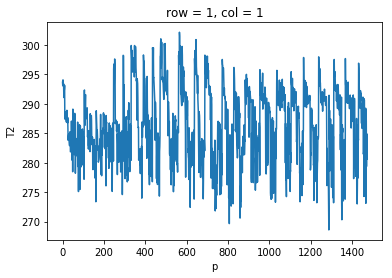

In [28]:
T[:,1,1].plot()

##### How to create a simple plot of p=0

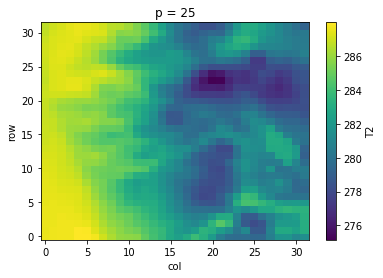

In [30]:
T.isel(p=25).plot()

##### How to create a timeseries plot over two locations using matplotlib

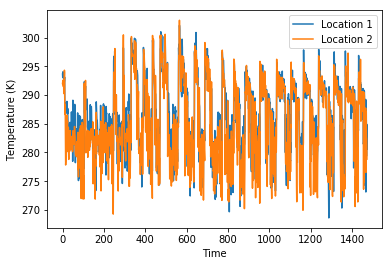

In [31]:
plt.plot(xf['p'],T[:,1,1], label='Location 1')
plt.plot(xf['p'],T[:,30,30], label='Location 2')
plt.ylabel('Temperature (K)')
plt.xlabel('Time')
plt.legend()

##### How to create a simple contour plot with matplotlib

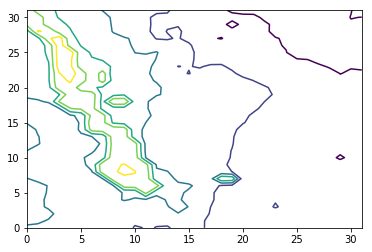

In [32]:
plt.contour(T[0,:,:])

#####  Create the same plot as above, but use the axis label provided by xarray

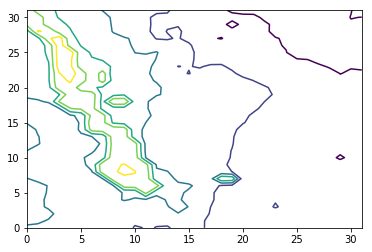

In [33]:
plt.contour(T.sel(p=0))


##### Same as above, but countour labels have been added

<a list of 10 text.Text objects>

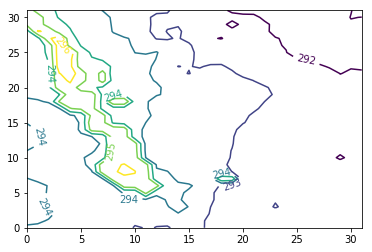

In [34]:
cs = plt.contour(T.sel(p=0))
plt.clabel(cs, fmt='%.0f', inline=True)

##### Set some variables that are used in the following examples

In [35]:
V = xf['V10_curr']
U = xf['U10_curr']
r = xf['row']
c = xf['col']

##### How to draw a countour plot with quivers

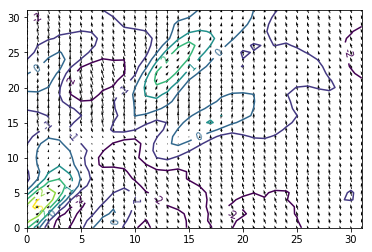

In [36]:
cs = plt.contour(U.sel(p=0))
plt.clabel(cs, fmt='%.0f', inline=True)
plt.quiver(r, c, U.sel(p=0), V.sel(p=0), pivot='middle')

##### How to draw a barb plot

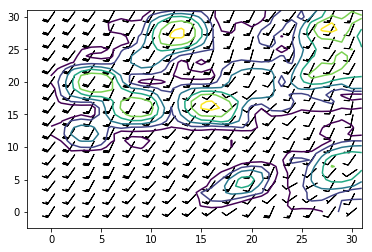

In [44]:
stride = 2
patch = 322
plt.contour(xf["REFL_COM_curr"].sel(p=patch))
plt.barbs(r[::stride], c[::stride], U.sel(p=patch)[::stride, ::stride], 
          V.sel(p=200)[::stride, ::stride], length=5, pivot='middle')

# Preparing data for the turorial

##### Declare all of the input and output variables

In [105]:
run_times = []
valid_times = []
# List of input variables
in_vars = ["REFL_COM_curr",
           "U10_curr", "V10_curr"]
# List of output variables
out_vars = ["RVORT1_MAX_future"]
in_data = []
out_data = []

##### Loop through each file and extract the relevant variables


In [106]:
for f in files:
    run_time = pd.Timestamp(f.split("/")[-1].split("_")[1])
    ds = xr.open_dataset(f)
    in_data.append(np.stack([ds[v].values for v in in_vars], axis=-1))
    out_data.append(np.stack([ds[v].values for v in out_vars], axis=-1))
    valid_times.append(ds["time"].values)
    run_times.append([run_time] * in_data[-1].shape[0])
    ds.close()

##### Stack the  data into single arrays instead of lists of arrays
This is done to make it easier to feed the data into the ML algorithms

In [107]:
all_in_data = np.vstack(in_data)
all_out_data = np.vstack(out_data)
all_run_times = np.concatenate(run_times)
all_valid_times = np.concatenate(valid_times)

##### Deallocate the lists of temporary arrays to save memory

In [108]:
del in_data[:], out_data[:], run_times[:], valid_times[:]
del in_data, out_data, run_times, valid_times

##### Find the maximum vorticity values in the file

In [109]:
max_vort = all_out_data[:, :, :, 0].max(axis=-1).max(axis=-1)
vort_thresh = 0.008
print(percentileofscore(max_vort, vort_thresh))
vort_labels = np.where(max_vort > vort_thresh, 1, 0)

97.47888754055326


##### Create some histograms that show the distribution of the data

Text(0,0.5,'Cumulative Distribution')

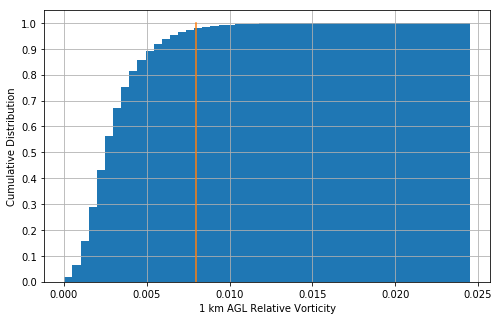

In [110]:
plt.figure(figsize=(8, 5))
plt.hist(max_vort, bins=50, cumulative=True, density=True)
plt.plot(np.ones(10) * vort_thresh, np.linspace(0, 1, 10))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid()
plt.xlabel("1 km AGL Relative Vorticity")
plt.ylabel("Cumulative Distribution")

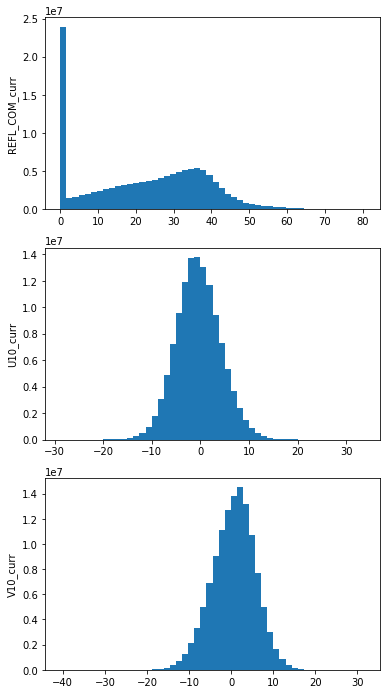

In [111]:
fig, axes = plt.subplots(all_in_data.shape[-1], 1, figsize=(6, all_in_data.shape[-1] * 4))
for a, ax in enumerate(axes):
    ax.hist(all_in_data[:, :, :, a].ravel(), 50)
    ax.set_ylabel(in_vars[a])

##### Plot a storm example using what we've gone over so far

Text(0.5,1,'Storm Example 112218 Valid 2016-06-22 23:00')

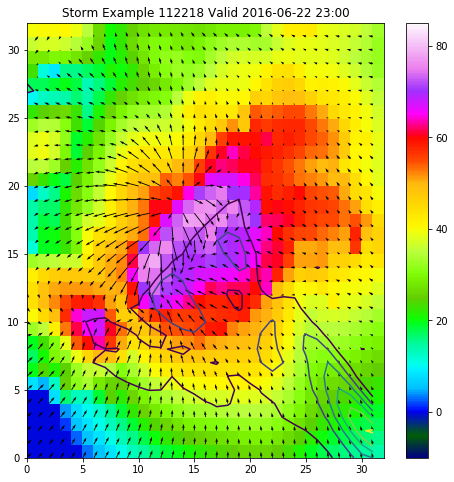

In [112]:
rot_ex = max_vort.argmax()
plt.figure(figsize=(8, 8))
plt.pcolormesh(all_in_data[rot_ex, :, :, 0], cmap="gist_ncar", vmin=-10, vmax=85)
plt.colorbar()
plt.quiver(all_in_data[rot_ex, :, :, 1], all_in_data[rot_ex, :, :, 2])
plt.contour(all_out_data[rot_ex, :, :, 0])
plt.title("Storm Example {0} Valid ".format(rot_ex) + pd.Timestamp(all_valid_times[rot_ex]).strftime("%Y-%m-%d %H:%M")) 

### Separating into training and test sets 
We need to separate the full data set into two different groups.  The first group is what we feed into the model to train it.  The second group is what we use to test with to see if the model performs as expected.  It's important to create the groups correctly by knowing your data.  For example, is your data time dependant? If so, would randomly assigning data to these groups make it harder for the model to pick up on patterns?  

Picking the correct amount of data to put in each group is equally as important.  Picking the incorrect amount of data (and also picking the incorrect groups) can cause overfitting.  This happens when the model that is generated isn't generalized enough for prediction.

You can try different combinations to see how it effects your model.

##### By date

In [120]:
split_date = pd.Timestamp("2015-01-01")
train_indices = np.where(all_run_times < split_date)[0]
test_indices = np.where(all_run_times >= split_date)[0]
print ("Size of training set: ",len(train_indices))
print ("Size of test set: ",len(test_indices))

Size of training set:  76377
Size of test set:  44760


##### By random index

In [123]:

percent_train = .8

indices = np.arange(all_in_data.shape[0])
np.random.shuffle(indices)

split = int(indices.size * percent_train)
print ("Splitting on index: ",split)

train_indices = indices[:split]
test_indices = indices[split:]

print("Size of training set: ",len(train_indices))
print("Size of test set: ",len(test_indices))

#print (train_indices)
#print (test_indices)


Splitting on index:  96909
Size of training set:  96909
Size of test set:  24228


##### Transforming patch data
Some machine learning models are sensitive to the center and variance of their input variables. Neural networks, by default, initialize their weights as small values near 0, so they may struggle to converge if the data do not have mean 0 and standard deviation 1. By rescaling the data, we can help models like neural networks converge faster. Some pre-processing techniques, like Prinicpal Component Analysis, also assume the data are normalized and will not work well if that assumption is violated. 

Scikit-learn offers multiple scalers for tabular data. StandardScaler applies mean and standard deviation normalization, while MinMaxScaler rescales the data to fit a fixed range.

In [130]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

refl = all_in_data[:, :, :, 0]

refl_stacked = refl.reshape(-1, refl.shape[1] * refl.shape[2])
scaler = StandardScaler()
scaler = scaler.fit(refl_stacked)
refl_norm = scaler.transform(refl_stacked)

refl_norm.shape

(121137, 1024)

#####  Using prinicpal component analysis to reduce the dimensionality of the different fields

Principal Component Analysis (PCA), also known as Empirical Orthogonal Functions (and a [bunch of other names](https://en.wikipedia.org/wiki/Principal_component_analysis)), is a technique for reducing the number of dimensions required to describe a set of data. PCA can be used to reduce the dimensions of the data by creating a weighted additive combination of every input variable. The principal components are sorted by how much variance in the data they explain. The singular value decomposition that produces the principal components initially has the same number of components as the number of input variables, but truncating the components with the smallest amount of variance allows one to keep the most important parts of the data and remove the rest. 

To apply PCA to spatial data, first flatten each image into a vector and then apply PCA. 

In [250]:
from sklearn.decomposition import PCA

num_comps = 15
num_vars = refl_norm.shape[1]

pc_obj = PCA(n_components=num_comps)
pc_train_data = pc_obj.fit_transform(refl_norm[train_indices])
pc_test_data = pc_obj.transform(refl_norm[test_indices])



This plot shows how much variance is cumulatively explained by each principal component.

Text(0,0.5,'Cumulative Explained Variance Ratio')

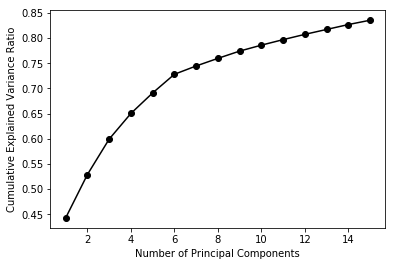

In [251]:
plt.plot(np.arange(1, num_comps + 1), np.cumsum(pc_obj.explained_variance_ratio_), 'ko-')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance Ratio")

We can visualize the weights for each component. The values of the weights are influenced both by the data and the shape of the domain. The component weights often consist of wavy patterns of increasing frequency as component number increases. These patterns have been observed in many datasets and are known as Buell Patterns. Methods like rotational PCA can reduce the effect of Buell patterns and make the weights more interpretable at the expense of making them no longer orthogonal.

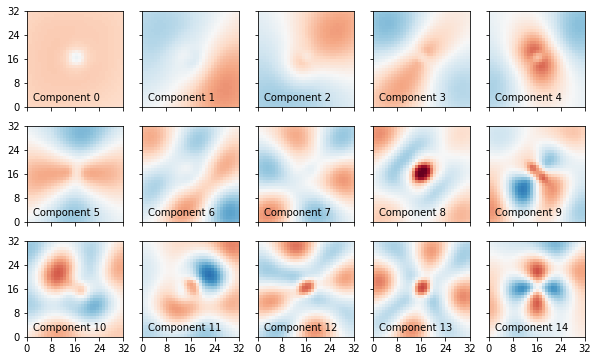

In [133]:
fig, axes = plt.subplots(3, 5, figsize=(10, 6), sharex=True, sharey=True)
abs_max = np.max(np.abs(pc_obj.components_))
for a, ax in enumerate(axes.ravel()):    
    ax.pcolormesh(pc_obj.components_[a].reshape(32, 32), vmin=-abs_max, vmax=abs_max, cmap="RdBu_r")
    ax.text(2, 2, "Component {0:d}".format(a))
    ax.set_xticks(np.arange(0, 36, 8))    
    ax.set_yticks(np.arange(0, 36, 8))

We can reconstruct a given example by adding more principal components together. As we add more components, finer scale details reappear.

Text(2,2,'Original')

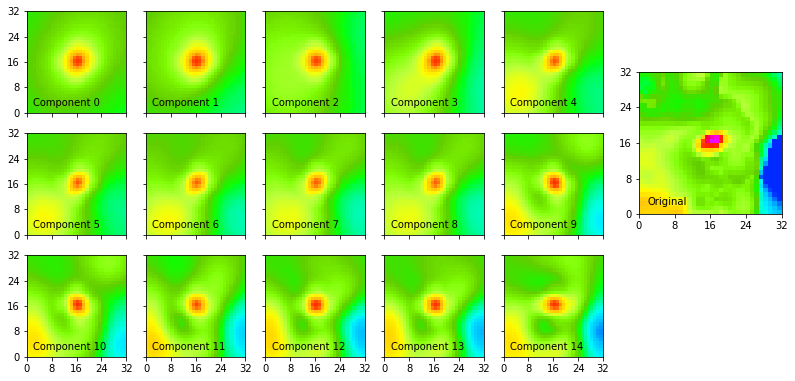

In [187]:
pc_test_temp = np.zeros(pc_test_data.shape, dtype="float32")
fig, axes = plt.subplots(3, 5, figsize=(10, 6), sharex=True, sharey=True)
plt.subplots_adjust(0, 0, 0.8, 0.8)
index = 1024
for a, ax in enumerate(axes.ravel()):    
    pc_test_temp[:, a] = pc_test_data[:, a]
    inverse = scaler.inverse_transform(pc_obj.inverse_transform(pc_test_temp))
    ax.pcolormesh(inverse[index].reshape(32, 32), vmin=-10, vmax=75, cmap="gist_ncar")
    ax.set_xticks(np.arange(0, 36, 8))    
    ax.set_yticks(np.arange(0, 36, 8))
    ax.text(2, 2, "Component {0:d}".format(a))
ax_true = fig.add_axes([0.85, 0.33, 0.198, 0.33])
ax_true.pcolormesh(all_in_data[test_indices][index][:, :, 0], vmin=-10, vmax=75, cmap="gist_ncar")
ax_true.set_xticks(np.arange(0, 36, 8))    
ax_true.set_yticks(np.arange(0, 36, 8))
ax_true.text(2, 2, "Original")


In [175]:
all_out_data[test_indices][:, :, 0].max(axis=-1).max(axis=-1).argmax()

11789

## Exercise
Transform the V-wind field for each storm into 10 principal components. Visualize the component weights and see what features are added by each component for an example storm from the testing data.

In [252]:
# Code goes here

